# WEEK 9: NLP in Vietnamese - PhoBERT for Sentiment Analysis

Nguyen Luu Phuong Ngoc Lam - 240106

## 1. Preparation

In [23]:
!pip install underthesea 
from underthesea import word_tokenize

In [24]:
# Library 

# Data Processing Libraries
import pandas as pd
import numpy as np

# Text Processing Libraries
import string
import regex as re
from wordcloud import WordCloud
from underthesea import word_tokenize

# Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModel, AutoTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from tqdm import tqdm 
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import confusion_matrix
model = AutoModel.from_pretrained("vinai/phobert-base", output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## 2. Load dataset and EDA

In [25]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)

df = pd.read_csv(file_path, header = None, names = ['label','content'])
df.head(10)

,label,content
0,0,máy dùng hay bị đơ máy
1,0,chỉ có dây cáp nguồn không có adapter sao sử d...
2,0,Chất lượng quá kém Mới dùng được 2 ngày loa ba...
3,0,Usb tôi vừa mới nhận usb này Rất bực bội vì cá...
4,2,Tuyệt vời. Hàng FPT cửa hàng
5,1,Chưa đo đúng bước chân rõ Nhiều khi gián đoạn ...
6,0,phủ sóng thấp quá đi khoảng 3 4m là mất sóng
7,1,Kết nối tốt Mối nối không khít gây đau tai 1 K...
8,0,2 Loa nhỏ nghe bị rè Âm thanh chưa tốt hơi thấ...
9,0,Đặt i12 shop giao i11 thất vọng


In [26]:
label_counts = df['label'].value_counts()
print("Label distribution:\n", label_counts)
# 0 - negative, 1 - neutral, 2 - positive

Label distribution:
 label
0    1105
2    1048
1     887
Name: count, dtype: int64


In [27]:
duplicates = df[df.duplicated(subset=['content'], keep=False)].sort_values(by='content')
print(duplicates[['content', 'label']])

                                                content  label
2511  Bình thường Cách đây 2 hôm mình có đặt mua thì...      1
820   Bình thường Cách đây 2 hôm mình có đặt mua thì...      1
1086  Bình thường Giao hàng nhanh sản phẩm tốt tùy n...      1
727   Bình thường Giao hàng nhanh sản phẩm tốt tùy n...      1
1749  Bình thường Sản phẩm ok Nhưng hàng giao quá ch...      1
...                                                 ...    ...
1608  ĐẶT MÀU CAM GIAO MÀU ĐEN Nhưng chất lượng máy ...      1
2695  đo sức khỏe không đúng nếu mua vì giá và không...      1
2002  đo sức khỏe không đúng nếu mua vì giá và không...      1
2421  Ổn nhưng chưa hài lòng lắm Mình mua sản phẩm c...      1
2490  Ổn nhưng chưa hài lòng lắm Mình mua sản phẩm c...      1

[84 rows x 2 columns]


In [28]:
df = df.drop_duplicates(subset=['content'])

In [29]:
print("Number of label rows: ", df['label'].count())
print("Number of content rows: ", df['content'].nunique())

Number of label rows:  2998
Number of content rows:  2998


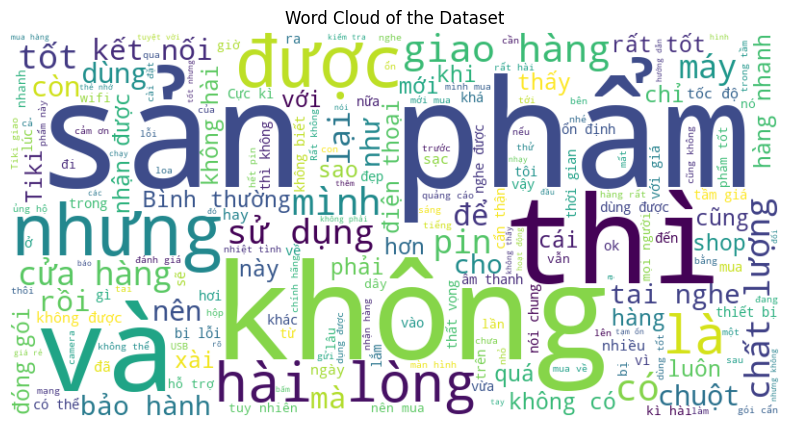

In [30]:
all_text = ' '.join(df['content'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of the Dataset')
plt.show()

In [31]:
def extract_emojis(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F700-\U0001F77F"  # alchemical symbols
        u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U0001FA00-\U0001FA6F"  # Chess Symbols
        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        u"\U00002702-\U000027B0"  # Dingbats
        u"\U000024C2-\U0001F251" 
        "]+", flags=re.UNICODE)
    
    return emoji_pattern.findall(text)

df['extracted_emojis'] = df['content'].apply(extract_emojis)
all_emojis = [emoji for sublist in df['extracted_emojis'] for emoji in sublist]
emoji_df = pd.DataFrame(all_emojis, columns=['emoji'])
df.drop(columns=['extracted_emojis'], inplace=True)

print("List of emoji:")
print(emoji_df['emoji'].unique())  

List of emoji:
['😆😆😆' '😢😢' '☺☺' '❤' '😌' '😁' '，']


## 3. Preprocessing Data

In [32]:
# Danh sách từ phủ định, tích cực, tiêu cực, trung tính và stopwords
not_list = ['chẳng', 'không', 'chưa', 'không_phải', 'đừng', 'chối']
pos_list = ['đẹp', 'tốt', 'thích', 'tuyệt', 'hay', 'ok', 'xuất_sắc', 'cảm_ơn']
nega_list = ['xấu', 'tệ', 'không_thích', 'chán', 'bực', 'dở', 'tệ_hại']
neutral_list = ['tạm_được', 'bình_thường', 'cũng_được', 'thường_thôi']  # Danh sách từ trung tính
stop_ws = (u'rằng', u'thì', u'là', u'mà')

def normalize_text(text):
    """
    Normalize the input text by removing unwanted characters, handling negations,
    and classifying sentiment into positive, negative, neutral, or not.
    """
    
    # Remove các ký tự kéo dài: vd: đẹppppppp
    text = re.sub(r'([A-Z])\1+', lambda m: m.group(1).upper(), text, flags=re.IGNORECASE)
    
    # Chuyển thành chữ thường
    text = text.lower()

    # Chuẩn hóa tiếng Việt, xử lý emoji, chuẩn hóa tiếng Anh, thuật ngữ
    replace_list = {
        '😆': 'pos', '😢': 'nega', '☺': 'pos', '❤': 'pos', '😌': 'pos', '😁': 'pos', '，': ' ',
    }
    
    for k, v in replace_list.items():
        text = text.replace(k, v)

    # Chuyển punctuation thành space
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    text = text.translate(translator)

    # Tokenize với format='text'
    tokens = word_tokenize(text, format='text')

    # Xử lý khoảng trắng thừa (nếu có) và chuẩn hóa lại
    text = re.sub(r'\s+', ' ', tokens).strip()  # Loại bỏ khoảng trắng thừa

    # Tokenize lại chuỗi văn bản đã chuẩn hóa
    tokens = text.split(' ')  # Tách lại thành danh sách từ

    # Loại bỏ stopwords
    texts = [word for word in tokens if word not in stop_ws]

    # List để lưu các nhãn cảm xúc
    sentiment_label = None

    # Xử lý phủ định và sentiment words
    len_text = len(texts)
    for i in range(len_text):
        cp_text = texts[i]
        if cp_text in not_list:  # Xử lý các từ phủ định
            numb_word = 2 if len_text - i - 1 >= 4 else len_text - i - 1
            for j in range(numb_word):
                if texts[i + j + 1] in pos_list:
                    sentiment_label = 'notpos'
                    texts[i + j + 1] = ''
                    break  # Dừng xử lý khi tìm thấy nhãn cảm xúc đầu tiên

                if texts[i + j + 1] in nega_list:
                    sentiment_label = 'notnega'
                    texts[i + j + 1] = ''
                    break  # Dừng xử lý khi tìm thấy nhãn cảm xúc đầu tiên
        else:  # Xử lý từ tích cực, tiêu cực và trung tính
            if cp_text in pos_list:
                sentiment_label = 'positive'
                break  # Dừng xử lý khi tìm thấy nhãn cảm xúc đầu tiên
            elif cp_text in nega_list:
                sentiment_label = 'negative'
                break  # Dừng xử lý khi tìm thấy nhãn cảm xúc đầu tiên
            elif cp_text in neutral_list:
                sentiment_label = 'neutral'
                break  # Dừng xử lý khi tìm thấy nhãn cảm xúc trung tính

    # Nếu không tìm thấy từ tích cực, tiêu cực hay phủ định, kiểm tra từ trung tính
    if not sentiment_label:
        for word in texts:
            if word in neutral_list:
                sentiment_label = 'neutral'
                break

    # Loại bỏ các chuỗi rỗng do xử lý trước đó
    texts = [word for word in texts if word]

    # Kết hợp lại thành câu đã chuẩn hóa
    text = ' '.join(texts).strip()

    # Thêm nhãn cảm xúc vào cuối câu nếu có
    if sentiment_label:
        text += ' ' + sentiment_label

    return text

text_samples = ['Sản phẩm này bình thường', 'Tôi rất thích món này', 'Đồ ăn ở đây tệ quá']
cleaned_texts = [normalize_text(text) for text in text_samples]

print(cleaned_texts)


['sản_phẩm này bình_thường neutral', 'tôi rất thích món này positive', 'đồ_ăn ở đây tệ quá negative']


In [33]:
## Apply all dataframe
df['clean_content'] = df['content'].apply(normalize_text)
df.sample(5)

,label,content,clean_content
2425,2,Chất lượng Chuột Có Dây Logitech B100 Hàng C...,chất_lượng chuột có dây logitech b100 hàng chí...
1632,0,dùng không biết được 1 tháng chưa mà tự dưng k...,dùng không biết được 1 tháng chưa tự_dưng khôn...
526,0,"tai nghe bị bóc tem , bóp méo và một bên tai n...",tai nghe bị bóc tem bóp_méo và một bên tai_nhe...
2645,1,"không có cục sạc ,máy thì tốt",không có cục sạc máy tốt positive
1748,2,các bạn mua hàng cửa hàng rất uy tín hàng chín...,các bạn mua hàng cửa_hàng rất uy_tín hàng chín...


## 4. Splitting Data

In [34]:
X_train, X_test, y_train, y_test = train_test_split( df['content'], df['label'], test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (2398,)
X_test shape: (600,)


In [ ]:
def get_vector(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    outputs = model(**inputs)
    return torch.mean(outputs.last_hidden_state, dim=1).detach().numpy()

# Convert texts to vectors
train_vectors = [get_vector(text) for text in X_train]
test_vectors = [get_vector(text) for text in X_test]

In [ ]:
train_vectors[0]

### 5. Apply data for classification downstream task

In [36]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long)
        }

class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/phobert-base")
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False
        )
        x = self.drop(output[1])  # Using the pooled output (output[1] is pooled output)
        x = self.fc(x)
        return x

def train(model, criterion, optimizer, train_loader, scheduler):
    model.train()
    losses = []
    correct = 0

    # Wrap the train_loader with tqdm for progress bar
    for data in tqdm(train_loader, desc="Training", leave=False):
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
        loss = criterion(outputs, targets)
        _, pred = torch.max(outputs, dim=1)

        correct += torch.sum(pred == targets)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        scheduler.step()

    print(f'Train Accuracy: {correct.double()/len(train_loader.dataset)} Loss: {np.mean(losses)}')

def eval(model, criterion, eval_loader):
    model.eval()
    losses = []
    correct = 0

    # Wrap the eval_loader with tqdm for progress bar
    with torch.no_grad():
        for data in tqdm(eval_loader, desc="Evaluating", leave=False):
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            _, pred = torch.max(outputs, dim=1)

            loss = criterion(outputs, targets)
            correct += torch.sum(pred == targets)
            losses.append(loss.item())

    accuracy = correct.double() / len(eval_loader.dataset)
    avg_loss = np.mean(losses)
    print(f'Eval Accuracy: {accuracy} Loss: {avg_loss}')
    return accuracy

def prepare_loaders(X, y, tokenizer, fold, max_len=120):
    skf = StratifiedKFold(n_splits=5)
    for f, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        if f == fold:
            break

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    train_dataset = SentimentDataset(X_train, y_train, tokenizer, max_len)
    val_dataset = SentimentDataset(X_val, y_val, tokenizer, max_len)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    return train_loader, val_loader



In [37]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
EPOCHS = 3
N_CLASSES = len(df['label'].unique())  # Assuming 'label' is the target column
model = SentimentClassifier(n_classes=N_CLASSES).to(device)

# Initialize optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(X_train) * EPOCHS)
criterion = nn.CrossEntropyLoss()

best_acc = 0

# Training Loop
for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}/{EPOCHS}')
    print('-'*30)
    train_loader, val_loader = prepare_loaders(X_train.values, y_train.values, tokenizer, fold=0)  # fold=0 as example, change for k-fold
    train(model, criterion, optimizer, train_loader, scheduler)
    val_acc = eval(model, criterion, val_loader)

    if val_acc > best_acc:
        torch.save(model.state_dict(), 'best_model.pth')
        best_acc = val_acc


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3
------------------------------


Train Accuracy: 0.6178310740354536 Loss: 0.8314999791483084


Eval Accuracy: 0.7770833333333333 Loss: 0.5489483912785847
Epoch 2/3
------------------------------


Train Accuracy: 0.8227320125130344 Loss: 0.4580616507679224


Eval Accuracy: 0.8145833333333333 Loss: 0.49798196107149123
Epoch 3/3
------------------------------


Train Accuracy: 0.859228362877998 Loss: 0.35906123320261635


Eval Accuracy: 0.825 Loss: 0.48532552147905034


### 6. Inference demo

In [40]:
# Define a function to preprocess the input text
def preprocess_input(text, tokenizer, max_len=120):
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    return encoding['input_ids'].to(device), encoding['attention_mask'].to(device)

# Define a function for inference
def predict_sentiment(text):
    input_ids, attention_mask = preprocess_input(text, tokenizer)
    
    # Make prediction
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
    # Get the predicted class
    _, prediction = torch.max(outputs, dim=1)
    return prediction.item()

# Sentiment classes (adjust based on your dataset)
classes = ['negative', 'neutral', 'positive']

# Example of inference
def demo_inference():
    # Example input text
    text = input("Enter text for sentiment analysis: ")

    # Get prediction
    predicted_class = predict_sentiment(text)

    # Print the result
    print(f"Predicted Sentiment: {classes[predicted_class]}")

# Run the demo
demo_inference()


Enter text for sentiment analysis:  Quá là vừa ý, tôi sẽ mua sản phẩm này lần hai!


Predicted Sentiment: positive


In [41]:
demo_inference()

Enter text for sentiment analysis:  Rất bực bội vì sản phẩm quá tệ, không xứng đáng giá tiền


Predicted Sentiment: negative


In [42]:
demo_inference()

Enter text for sentiment analysis:  Với giá tiền này thì nói chung cũng tạm chấp nhận được, tiền nào của nấy thôi


Predicted Sentiment: neutral


In [45]:
demo_inference()

Enter text for sentiment analysis:  không có gì để chê


Predicted Sentiment: negative


In [46]:
demo_inference()

Enter text for sentiment analysis:  sử dụng được nhưng không biết có bền không, dùng một thời gian sẽ quay lại review


Predicted Sentiment: neutral
